# Place Cell Analyses

Analyze TH data for place cells.

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np

from convnwb.io import load_nwbfile

from spiketools.spatial.occupancy import (compute_occupancy, compute_bin_edges, compute_bin_assignment,
                                          compute_bin_counts_pos, normalize_bin_counts)
from spiketools.spatial.utils import compute_pos_ranges, compute_bin_width
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.spatial import plot_positions, plot_heatmap, create_heat_title
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import color_pval
from spiketools.utils import set_random_seed
from spiketools.utils.extract import get_range, get_values_by_time_range, get_values_by_times
from spiketools.utils.epoch import epoch_data_by_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from models import create_df_place, fit_anova_place

## Settings

In [5]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [6]:
# Define the base data folder
data_folder = '/Users/tom/Data/JacobsLab/WVTH/NWB'
#data_folder = '/scratch/tom.donoghue/TH/NWB'

In [7]:
# Define session information
session = {
    'experiment' : 'THF',
    'subject' : 'wv002',
    'session' : 1    
}

In [8]:
# Define bins to use
#bins = [7, 21]
#bins = [9, 12]
bins = [6, 10]

# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

In [9]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'
# shuffle_approach = 'BINCIRC'
n_surrogates = 25

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {'shuffle_min' : 20000}

In [10]:
# Set example unit to analyze
uind = 3

In [11]:
# Set which analysis method to run
METHOD = 'INFO'

## Load Data

In [12]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

#### Extract Time Definitions

In [13]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

#### Extract Position Data

In [14]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [15]:
# Get boundary ranges
x_boundary = nwbfile.acquisition['boundaries']['x_range'].data[:]
z_boundary = nwbfile.acquisition['boundaries']['z_range'].data[:]

# Add a buffer to the z-range (for tower transport)
z_boundary = z_boundary + np.array([-15, 15])

#### Extract Boundaries

In [16]:
# Collect together boundary ranges
area_range = [x_boundary, z_boundary]
print('X boundary range: ', x_boundary)
print('Z boundary range: ', z_boundary)

X boundary range:  [349.8549 419.8549]
Z boundary range:  [293.     424.3358]


#### Select position traces from navigation periods

In [17]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

In [18]:
# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

#### Extract Spike Data

In [19]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 64
Number to keep:  54


In [20]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

## Position Data

In [21]:
# Compute position ranges
x_range, z_range = compute_pos_ranges(positions)

In [22]:
# Check ranges of positon
print('Position X-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*x_range, x_range[1] - x_range[0]))
print('Position Z-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*z_range, z_range[1] - z_range[0]))

Position X-range:  365.08 - 418.59 (53.51)
Position Z-range:  301.92 - 422.94 (121.02)


In [23]:
# Get position values for each spike
spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=0.1)

In [24]:
# Check binning
x_bin_edges, y_bin_edges = compute_bin_edges(positions, bins, area_range)

In [25]:
# Check bin sizes
print('Bin widths: {:1.2f}, {:1.2f}'.format(compute_bin_width(x_bin_edges), compute_bin_width(y_bin_edges)))

Bin widths: 11.67, 13.13


### Occupancy

In [26]:
# Collect settings for occupancy
occ_kwargs = {'minimum' : min_occ, 'normalize' : False, 'set_nan' : True}

In [27]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins, area_range,
                        speed, speed_thresh, time_thresh, **occ_kwargs)

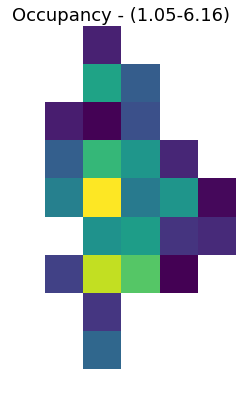

In [28]:
# Plot occupancy
plot_heatmap(occ, figsize=(5, 7), title=create_heat_title('Occupancy', occ))

## Check spike locations

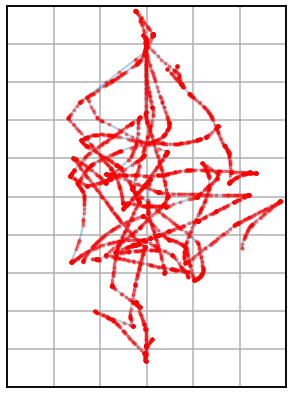

In [29]:
# Plot the map across all position traces (plotted per trial)
plot_positions(positions_trials, spike_positions,
               x_bins=x_bin_edges, y_bins=y_bin_edges,
               xlim=list(x_boundary), ylim=list(z_boundary),
               figsize=(5, 7))

## Compute Binned Spatial Firing

In [30]:
# # Compute spatial bin assignments for each spike
#x_binl, y_binl = compute_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)

In [31]:
# Compute summary map of bin firing
bin_firing = compute_bin_counts_pos(spike_positions, bins, area_range)

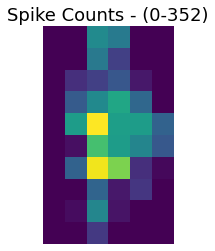

In [32]:
# Check the firing map
plot_heatmap(bin_firing, title=create_heat_title('Spike Counts', bin_firing))

In [33]:
# Normalize bin firing by occupancy
normed_bin_firing = normalize_bin_counts(bin_firing, occ)

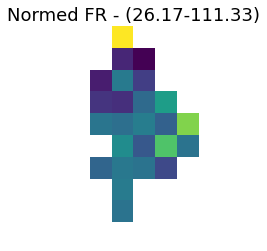

In [34]:
# Plot occupancy-normalized spatial firing
plot_heatmap(normed_bin_firing, title=create_heat_title('Normed FR', normed_bin_firing))

## Individual trials

In [35]:
# Set a trial index to get data for
t_ind = 5

In [36]:
# Get the number of trials
n_trials = len(nwbfile.trials)
assert t_ind < n_trials
print('Number of trials: {}'.format(n_trials))

Number of trials: 8


In [37]:
# Get the navigation time ranges
t_st = nwbfile.trials.navigation_start[t_ind]
t_en = nwbfile.trials.navigation_stop[t_ind]

In [38]:
# Get data for selected trial: trial positions, spikes, and spike positions
trial_times, trial_pos = get_values_by_time_range(ptimes, positions, t_st, t_en)
trial_spikes = get_range(spikes, t_st, t_en)
_, trial_speed = get_values_by_time_range(ptimes, speed, t_st, t_en)
spike_positions_trial = get_values_by_times(trial_times, trial_pos, trial_spikes, threshold=0.25)

In [39]:
# Compute the trial level occupancy
t_occ = compute_occupancy(trial_pos, trial_times, bins, area_range,
                          trial_speed, speed_thresh, time_thresh, **occ_kwargs)

In [40]:
# Compute the bin firing for the selected trial
bin_firing_trial = compute_bin_counts_pos(spike_positions_trial, bins, area_range, occupancy=None)

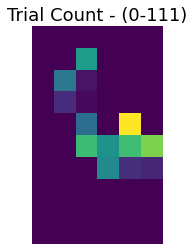

In [41]:
# Plot firing heatmap of the example trial
plot_heatmap(bin_firing_trial, title=create_heat_title('Trial Count', bin_firing_trial))

## Statistical Analyses

In [42]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

## Compute Spatial Information

In [43]:
# Compute the spatial information
spike_info = compute_spatial_information(normed_bin_firing, occ)
print(spike_info)

0.05514690129410535


### Shuffle Comparisons

In [44]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    bin_firing = compute_place_bins(stimes, positions, ptimes, bins, 
                                    area_range, speed, speed_thresh, time_thresh)
    surrs[ind] = compute_spatial_information(bin_firing, occ, normalize=True)

In [45]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(spike_info, surrs, verbose=True)

p-value: 1.00
z-score: -1.33


## Compute ANOVA

In [46]:
# Collect place firing, organized per trial
place_trial = compute_trial_place_bins(spikes, positions, ptimes, bins, nav_starts, nav_stops, 
                                       area_range, speed, speed_thresh, time_thresh,
                                       flatten=True, **occ_kwargs)

In [47]:
# Create the dataframe
df = create_df_place(place_trial, drop_na=True)

In [48]:
# Fit the ANOVA, and get the f-value
f_val = fit_anova_place(df)
f_val

2.83586964136939

### Shuffle Comparisons

In [49]:
# Create shuffles
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

In [50]:
# Compute measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    place_trial = compute_trial_place_bins(shuffle, positions, ptimes, bins, nav_starts, nav_stops,
                                           area_range, speed, speed_thresh, time_thresh,
                                           flatten=True, **occ_kwargs)
    surrogates[ind] = fit_anova_place(create_df_place(place_trial))

In [51]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=True)

p-value: 0.00
z-score: 3.21


## All Cells

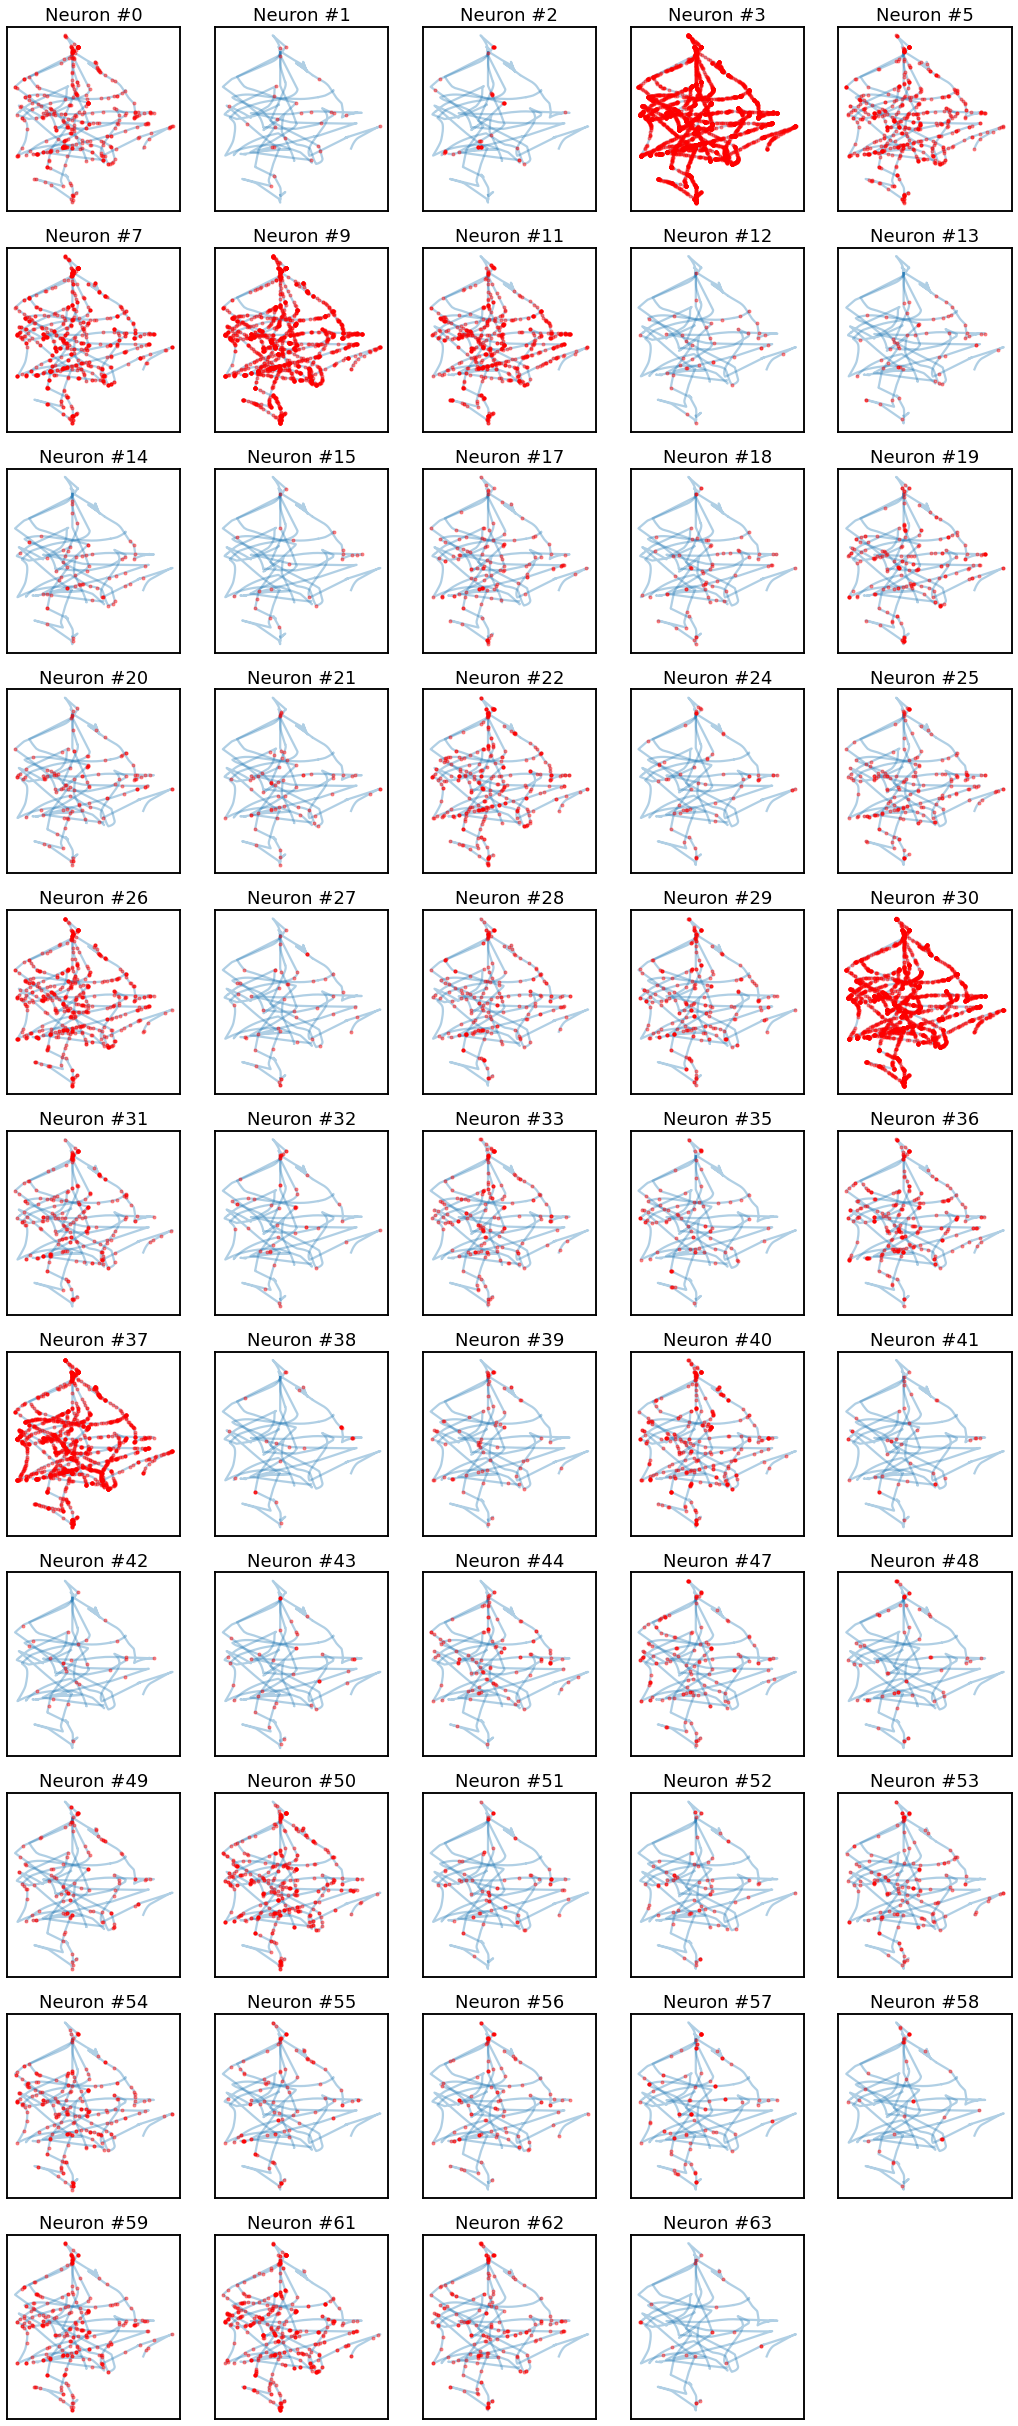

In [52]:
# Examine spatial firing across all cells
for ii, ax in zip(keep_inds, make_axes(n_keep)):
    spikes = nwbfile.units.get_unit_spike_times(ii)    
    spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=0.25)
    plot_positions(positions_trials, spike_positions, title='Neuron #{}'.format(ii), ax=ax)

In [55]:
# # Examine spatial firing across all cells
# for ii, ax in zip(keep_inds, make_axes(n_keep)):

#     spikes = nwbfile.units.get_unit_spike_times(ii)

#     # Compute spatially binned firing map
#     bin_firing = compute_place_bins(spikes, positions, ptimes, bins, area_range,
#                                     speed, speed_thresh, time_thresh, occ)
    
#     # Compute real data value
#     if METHOD == 'INFO':
#         data_value = compute_spatial_information(bin_firing, occ, normalize=False)

#     if METHOD == 'ANOVA':
#         place_trial = compute_trial_place_bins(spikes, positions, ptimes, bins, nav_starts, nav_stops,
#                                                area_range, speed, speed_thresh, time_thresh,
#                                                flatten=True, **occ_kwargs)
#         df = create_df_place(place_trial)
#         data_value = fit_anova_place(df)

#     surrogates = np.zeros(n_surrogates)
#     times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
#     for ind, shuffle in enumerate(times_shuffle):

#         if METHOD == 'INFO':            
#             bf_shuffle = compute_place_bins(shuffle, positions, ptimes, bins, area_range,
#                                             speed, speed_thresh, time_thresh, occ)
#             surrogates[ind] = compute_spatial_information(bf_shuffle, occ, normalize=False)

#         if METHOD == 'ANOVA':
#             place_trial = compute_trial_place_bins(shuffle, positions, ptimes, bins, nav_starts, nav_stops,
#                                                    area_range, speed, speed_thresh, time_thresh,
#                                                    flatten=True, **occ_kwargs)
#             surrogates[ind] = fit_anova_place(create_df_place(place_trial))

#     # Compute z-score & p-value based on surrogates
#     p_val, z_score = compute_surrogate_stats(data_value, surrogates, plot=False, ax=ax)    

#     # Plot occupancy-normalized spatial firing
#     plot_heatmap(bin_firing, title=create_heat_title('U{}'.format(ii), bin_firing, z_score, p_val),
#                  title_color=color_pval(p_val), title_fontsize=12, ax=ax)